# Multi-genre classification of heavy metal lyrics

The aim of this notebook is to demonstrate a machine learning approach to tagging heavy metal songs with genre labels based on their lyrics alone. The task is to develop a model which will predict for a given piece of text which genre(s) describe the text well.

This notebook will implement and discuss the usage of:
* Binary relevance as a multi-label classification framework
* Multi-label classification cross-validation and evaluation metrics
* Bag-of-words text representation (and why it is favorable over word embeddings for this task)
* Oversampling methods to curb the effects of imbalanced datasets
* A wide range of different classification models including:
    * Logistic regression
    * Bayesian methods
    * Ensemble methods
    * Neural networks

## Table of contents

1. [Imports](#imports)

1. [Data](#data)

1. [Multi-label classification tools](#mlctools)

1. [Evaluation metrics](#metrics)

1. [Pipeline](#pipeline)

1. [Hyperparameter tuning](#tuning)

1. [Logistic regression](#logreg)

1. [SGD classifier](#sgd)

1. [Naive Bayes](#naivebayes)

    * [Multinomial Naive Bayes](#multinomialnb)

    * [Complement Multinomial Naive Bayes](#complementnb)

    * [Bernoulli Naive Bayes](#bernoullinb)

1. [Random forest](#rf)

1. [Gradient boosted model](#gbm)

1. [Neural network](#nn)

1. [Stacked model](#stacking)

1. [Test on new lyrics](#test)

<a id='imports'></a>
## Imports

In [1]:
import glob
import os
import re
from copy import deepcopy
import numpy as np
import pandas as pd
import scipy
from scipy.sparse.csr import csr_matrix
from scipy.sparse.lil import lil_matrix
import itertools

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
sns.set(font_scale=2)

from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score, \
confusion_matrix, multilabel_confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB

from skmultilearn.model_selection import IterativeStratification
from skmultilearn.problem_transform import BinaryRelevance, ClassifierChain, LabelPowerset

from keras.models import Sequential
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping

import lightgbm as lgb


import sys
sys.path.append('../scripts/')

from nlp import tokenize
from mlsol import MLSOL
import lyrics_utils as utils

#### Fix random seeds

In [13]:
import random
import tensorflow.python.keras.backend as K 
sess = K.get_session()

seed = 0
os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
np.random.seed(seed)
tf.set_random_seed(seed)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

NameError: name 'tf' is not defined

<a id='data'></a>
## Data

See the previous chapters for more discussion about the data set. The data set is formatted as an array comprised of one independent variable (lyrics, retrieved from [Dark Lyrics](http://darklyrics.com)) and five dependent variable labels (genres, retrieved from [Metal-Archives](https://www.metal-archives.com)), for each row (song). Here are some things to keep in mind about the data:
* Each song can belong to any one or more, or none, of the genres. For example, a song can be labeled as thrash metal, or both thrash and power metal, and so on, or it can be unlabeled; it can therefore be predicted to be any combination of labels, or unlabeled, as well. This makes the task of tagging song lyrics with the appropriate genre labels a multi-label classification problem.
* The dataset is multi-lingual, since heavy metal spans many languages around the world. This will affect classification since there are correlations between genres and country of origin, as show in the previous chapter.
* The length of song lyrics can vary wildly, but this won't be a big issue in a bag-of-words representation.

In [2]:
df = pd.read_csv('../songs-ml-10pct.csv')
X = df.pop('lyrics').values
y = df.values
genres = df.columns
print(f"number of songs: {X.shape[0]}")
print(f"number of labels: {y.shape[1]}")
print(f"labels: {list(genres)}")

number of songs: 109633
number of labels: 5
labels: ['black', 'death', 'heavy', 'power', 'thrash']


<a id='mlctools'></a>
## Multi-label classification methods

**Binary relevance** is the simplest method of classifying multiple labels at once; it trains an independent classifier for each label, breaking the multi-label problem down into many binary classification problems ([Zhang, M., Li, Y., Liu, X., et al, 2018](http://palm.seu.edu.cn/zhangml/files/FCS'17.pdf)). In this context a binary classifier would be trained on each genre, and a song's genre tags predicted by concatenating the predictions of all genre classifiers. The advantage of this method is that the number of classifiers needed is equal to the number of labels, so the computational cost scales linearly with how many labels we want to predict. However, by assuming that the labels are independent, this method fails to capture correlations between labels. For example, the "heavy" and "power" genre labels are more likely to appear together, so an song's likelihood of being tagged as power metal should be higher if it is also tagged as heavy metal as opposed to, say, black metal. Another issue is that each binary classifier will face a class imbalance problem due to the sparsity of genre tags.

In the **classifier chain** method, a classifier is trained on one label and its output is fed as an additional feature to the next label, and so on until all labels have been exhausted ([Read, J., Pfahringer, B., Holmes., G, Frank, E. 2011](https://www.cs.waikato.ac.nz/~eibe/pubs/chains.pdf)). This again requires only as many classifiers as there are labels, but unlike binary relevance it does learn correlations between labels. However, the correlations it is capable of learning can vary with different chain orders.

Unlike the above two methods, which transform the multi-label problem into multiple independent binary classification problems, the **label powerset** method transforms it into a single multi-class problem by treating every combination of labels as its own class. For example, from the genres in the metal lyrics dataset, "black" + "death", "black" + "power", "black" + "death" + "power" would each yield a new class. This tackles the issue of correlated labels head-on by treating correlations as classes on their own, but comes at the cost of having smaller class sizes to train on and consequently an even bigger class imbalance problem. This issue inspired the **RAndom k-labELsets (RAKEL)** method, which uses an ensemble of classifiers, each trained on a random subset of labels ([Rokach, L., Schclar, A., Itach, E. 2013](https://arxiv.org/ftp/arxiv/papers/1307/1307.1769.pdf)).

In [ ]:
class BinaryRelevance:
    def __init__(self, classifier, labels, thresholds=None):
        self.classifier = classifier
        self.labels = labels
        self.classifiers_ = []
        self.thresholds = thresholds

    def fit(self, X, y):
        for i, label in enumerate(self.labels):
            print('training binary classifier for label: {}'.format(label))
            clf = deepcopy(self.classifier)
            clf.fit(X, y[:, i])
            self.classifiers_.append((label, clf))

    def predict(self, X):
        return self._predict(X).astype(int)

    def predict_proba(self, X):
        return self._predict(X, return_prob=True)

    def _predict(self, X, return_prob=False):
        y = np.zeros((X.shape[0], len(self.classifiers_)))
        for i, (label, clf) in enumerate(self.classifiers_):
            if return_prob:
                y[:, i] = clf.predict_proba(X)[:, 1]
            elif self.thresholds is not None:
                y[:, i] = (clf.predict_proba(X)[:, 1] > self.thresholds[i])
            else:
                y[:, i] = clf.predict(X)
        return y

    def cross_validate(self, X, y, n_splits=5, verbose=False):
        kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
        y_prob, y_valid = np.zeros(y.shape), np.zeros(y.shape)
        for i, label in enumerate(self.labels):
            if verbose:
                print("Training on label '{}'".format(label))
            scores = np.zeros((n_splits, 4))
            confusion_matrices = np.zeros((n_splits, 2, 2))
            for j, (train_idx, valid_idx) in enumerate(kfold.split(X, y[:, i])):
                if verbose:
                    print("Fold {}/{}".format(j + 1, n_splits))
                X_fold_train, y_fold_train = X[train_idx], y[train_idx, i]
                X_fold_valid, y_fold_valid = X[valid_idx], y[valid_idx, i]
                clf = deepcopy(self.classifier)
                clf.fit(X_fold_train, y_fold_train)
                try:
                    y_fold_prob = clf.predict_proba(X_fold_valid)[:, 1]
                except AttributeError:
                    y_fold_prob = clf.predict(X_fold_valid).reshape(-1)
                y_prob[valid_idx, i] = y_fold_prob
                y_valid[valid_idx, i] = y_fold_valid
                y_fold_pred = y_fold_prob.round()
                scores[j, 0] = balanced_accuracy_score(y_fold_valid, y_fold_pred)
                scores[j, 1] = precision_score(y_fold_valid, y_fold_pred)
                scores[j, 2] = recall_score(y_fold_valid, y_fold_pred)
                scores[j, 3] = f1_score(y_fold_valid, y_fold_pred)
                confusion_matrices[j] = confusion_matrix(y_fold_valid, y_fold_pred)
            if verbose:
                avg_accuracy, avg_precision, avg_recall, avg_f1 = scores.mean(axis=0)
                std_accuracy, std_precision, std_recall, std_f1 = scores.std(axis=0)
                print("CV scores:")
                print("Accuracy:    {:.2f} +/- {:.2f}".format(avg_accuracy, std_accuracy))
                print("Precision:   {:.2f} +/- {:.2f}".format(avg_precision, std_precision))
                print("Recall:      {:.2f} +/- {:.2f}".format(avg_recall, std_recall))
                print("F1-score:    {:.2f} +/- {:.2f}".format(avg_f1, std_f1))
                print("Average confusion matrix:")
                print(confusion_matrices.mean(axis=0) / confusion_matrices.sum() * n_splits)
        return MultiLabelClassification(y_valid, y_prob, labels=self.labels)

In [ ]:
class ClassifierChain:
    def __init__(self, classifier, labels):
        self.classifier = classifier
        self.labels = labels
        self.classifiers_ = []

    def fit(self, X, y, verbose=False):
        y_chain = np.zeros((y.shape[0], y.shape[1] - 1))
        for i in range(y.shape[1]):
            if verbose:
                print('training binary classifier for label: {}'.format(i))
            X_ = X.copy()
            y_ = y[:, i]
            clf = deepcopy(self.classifier)
            if isinstance(clf, Pipeline):
                for name, step in clf.steps:
                    try:
                        X_ = step.fit_transform(X_)
                    except AttributeError:
                        try:
                            if len(X_.shape) > 1:
                                X_, y_ = step.fit_resample(X_[:, : X_.shape[1]], y_)
                            else:
                                X_, y_ = step.fit_resample(X_, y_)
                        except AttributeError:
                            if i > 0:
                                X_ = np.concatenate((X_, y_chain[:, : i]), axis=1)
                            step.fit(X_, y_)
                            y_pred = step.predict(X_).reshape(-1)
                            print(X_.shape, y_.shape, y_pred.shape)
            else:
                if i > 0:
                    X_ = np.concatenate((X_, y_chain[:, : i]), axis=1)
                clf.fit(X_, y_)
                y_pred = clf.predict(X_).reshape(-1)
            y_chain[:, i] = y_pred
            self.classifiers_.append(clf)

    def predict(self, X):
        return self._predict(X)

    def predict_proba(self, X):
        return self._predict(X, return_prob=True)

    def _predict(self, X, return_prob=False):
        y, y_chain = np.zeros((2, X.shape[0], len(self.classifiers_)))
        for i, clf in enumerate(self.classifiers_):
            X_ = X.copy()
            y_ = y[:, i]
            if isinstance(clf, Pipeline):
                for name, step in clf.steps:
                    try:
                        X_ = step.transform(X_)
                    except AttributeError:
                        try:
                            if len(X_.shape) > 1:
                                X_, y_ = step.resample(X_[:, : X_.shape[1]], y_)
                            else:
                                X_, y_ = step.resample(X_, y_)
                        except AttributeError:
                            if i > 0:
                                X_ = np.concatenate((X_, y_chain[:, : i]), axis=1)
                            y_pred = step.predict(X_).reshape(-1)
                            y_prob = step.predict_proba(X_)[:, 1].reshape(-1)
            else:
                if i > 0:
                    X_ = np.concatenate((X_, y_chain[:, : i]), axis=1)
                y_pred = clf.predict(X_).reshape(-1)
                y_prob = clf.predict_proba(X_)[:, 1].reshape(-1)
            y_chain[:, i] = y_pred
            if return_prob:
                y[:, i] = y_prob
            else:
                y[:, i] = y_pred
        return y

    def cross_validate(self, X, y, n_splits=5, verbose=False):
        kfold = KFold(n_splits=n_splits, shuffle=True, random_state=0)
        y_prob, y_valid = np.zeros(y.shape), np.zeros(y.shape)
        scores = np.zeros((len(self.labels), n_splits, 4))
        confusion_matrices = np.zeros((len(self.labels), n_splits, 2, 2))
        for i, (train_idx, valid_idx) in enumerate(kfold.split(X, y)):
            if verbose:
                print("Fold {}/{}".format(i + 1, n_splits))
            X_fold_train, y_fold_train = X[train_idx], y[train_idx]
            X_fold_valid, y_fold_valid = X[valid_idx], y[valid_idx]
            clf = deepcopy(self)
            clf.fit(X_fold_train, y_fold_train)
            try:
                y_fold_prob = clf.predict_proba(X_fold_valid)
            except AttributeError:
                y_fold_prob = clf.predict(X_fold_valid)
            y_prob[valid_idx, :] = y_fold_prob
            y_valid[valid_idx, :] = y_fold_valid
            y_fold_pred = y_fold_prob.round()
            for j, label in enumerate(self.labels):
                scores[j, i, 0] = balanced_accuracy_score(y_fold_valid, y_fold_pred)
                scores[j, i, 1] = precision_score(y_fold_valid, y_fold_pred)
                scores[j, i, 2] = recall_score(y_fold_valid, y_fold_pred)
                scores[j, i, 3] = f1_score(y_fold_valid, y_fold_pred)
                confusion_matrices[j, i] = confusion_matrix(y_fold_valid, y_fold_pred)
        if verbose:
            for j, label in enumerate(self.labels):
                avg_accuracy, avg_precision, avg_recall, avg_f1 = scores[j].mean(axis=0)
                std_accuracy, std_precision, std_recall, std_f1 = scores[j].std(axis=0)
                print("CV scores for label {}:".format(label))
                print("Accuracy:    {:.2f} +/- {:.2f}".format(avg_accuracy, std_accuracy))
                print("Precision:   {:.2f} +/- {:.2f}".format(avg_precision, std_precision))
                print("Recall:      {:.2f} +/- {:.2f}".format(avg_recall, std_recall))
                print("F1-score:    {:.2f} +/- {:.2f}".format(avg_f1, std_f1))
                print("Average confusion matrix:")
                print(confusion_matrices[j].mean(axis=0) / confusion_matrices[j].sum() * n_splits)
        return MultiLabelClassification(y_valid, y_prob, labels=self.labels)

<a id='metrics'></a>
## Evaluation metrics

Since binary relevance involves training independent binary classifiers, each classifier can be evaluated during training and cross-validation using the familiar binary classification metrics.

However, evaluating the overall results requires metrics designed for the multi-label output, which are more complicated than the usual evaluation metrics ([Zhang, M., Zhou, Z. 2014](https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/tkde13rev.pdf)). If $h(\mathbf{x}_i)$ is the model which predicts the labels $Y_i$ based on the independent variables $\mathbf{x}_i$, then over $p$ observations the accuracy, precision, recall, and F scores are defined as

\begin{align}
\mathrm{accuracy}(h) &= \frac{1}{p}\sum_{i=1}^{p}(\mathrm{fraction\ of\ labels\ in\ common}) &= \frac{1}{p}\sum_{i=1}^{p}\frac{|Y_i \cap h(\mathbf{x}_i)|}{|Y_i \cup h(\mathbf{x}_i)|}\\
\mathrm{precision}(h) &= \frac{1}{p}\sum_{i=1}^{p}(\mathrm{fraction\ of\ predicted\ labels\ that\ are\ correct}) &= \frac{1}{p}\sum_{i=1}^{p}\frac{|Y_i \cap h(\mathbf{x}_i)|}{|h(\mathbf{x}_i)|}\\
\mathrm{recall}(h) &= \frac{1}{p}\sum_{i=1}^{p}(\mathrm{fraction\ of\ true\ labels\ that\ were\ predicted\ correctly}) &= \frac{1}{p}\sum_{i=1}^{p}\frac{|Y_i \cap h(\mathbf{x}_i)|}{|Y_i|}\\
\mathrm{F_1\ score}(h) &= \mathrm{harmonic\ mean\ of\ precision\ and\ recall} &= 2 \left[ \frac{\mathrm{precision}(h) \cdot \mathrm{recall}(h)}{\mathrm{precision}(h) + \mathrm{recall}(h)} \right]
\end{align}

Another useful metric is the Hamming loss, which is the mean symmetric difference (non-matching genre tags) between the two sets:

$$\mathrm{Hamming}(h) = \frac{1}{p} \sum_{i=1}^{p} |h(\mathbf{x}_i\Delta Y_i|$$

The receiver operating characteristic (ROC) is a common metric for binary classification problems that can be easily extended to multi-label problems. ROC measures the ratio of true positive rate to false positive rate as a function of classification threshold. An ROC curve is generated by varying the threshold over its full range, and the area under the curve (ROC AUC) is often used as another evaluation metric. This can be micro- or macro-averaged across all binary classifiers to evaluate the full multi-label classification model.

In [3]:
class MultiLabelClassification:
    """Multi-label classification results and evaluation metrics.

    Parameters
    ----------
    true : `numpy.ndarray`
        True values (n_samples, n_labels).

    pred : `numpy.ndarray`
        Predicted probabilities (n_samples, n_labels).

    pred_class : `numpy.ndarray`
        Classification results (n_samples, n_labels).

    labels : array-like
        Label names (str).

    threshold : float or array-like
        If float, `thresh` is a decision threshold for all labels.
        If array-like, `thresh` must be length n_labels, with each
        value a decision threshold for that respective label.


    Attributes
    ----------
    n_samples : int
        Number of samples (rows in `self.true`).

    n_labels : int
        Number of labels (columns in `self.true`).

    accuracy_score : float
        Number of labels in common / overall labels (true and predicted).

    precision_score : float
        Proportion of predicted labels that are correct.

    recall_score : float
        Proportion of true labels that were predicted.

    f1_score : float
        Harmonic mean of precision_score and recall_score.

    hamming_loss : float
        Symmetric difference b/w pred and true labels (true XOR pred).


    Methods
    -------
    print_report
    best_thresholds
    roc_auc_score
    plot_roc_curve
    plot_precision_recall_curve
    to_csv
    from_csv
    """

    def __init__(
            self,
            true,
            pred=None,
            pred_class=None,
            labels=None,
            threshold=0.5
    ):
        self.true = true.astype(int)
        self.pred = pred
        self.threshold = threshold
        if pred_class is None:
            pred_class = np.zeros_like(self.pred, dtype=int)
            if hasattr(self.threshold, '__iter__'):
                thresh_tile = np.ones_like(self.true) * self.threshold
            else:
                thresh_tile = np.tile(self.threshold, (self.true.shape[0], 1))
            pred_class[self.pred > thresh_tile] = 1
        self.pred_class = pred_class
        self.n_samples, self.n_labels = self.true.shape
        if labels is not None:
            if len(labels) == self.n_labels:
                self.labels = np.array(labels, dtype='object')
            else:
                raise ValueError(
                    f"len(labels)={len(labels)} does not match "
                    f"true.shape[1]={self.n_labels}")
        else:
            self.labels = np.arange(self.true.shape[1]).astype(str).astype('object')

    @property
    def __intersection(self):
        return self.true * self.pred_class

    @property
    def __union(self):
        return np.minimum(1, self.true + self.pred_class)

    @property
    def accuracy_score(self):
        return np.nanmean(self.__intersection.sum(1) / self.__union.sum(1))

    @property
    def precision_score(self):
        return np.nanmean(self.__intersection.sum(1) / self.pred_class.sum(1))

    @property
    def recall_score(self):
        return np.nanmean(self.__intersection.sum(1) / self.true.sum(1))

    @property
    def f1_score(self):
        prec = self.precision_score
        rec = self.recall_score
        return 2 * prec * rec / (prec + rec)

    @property
    def hamming_loss(self):
        delta = np.zeros(self.true.shape[0])
        for i in range(delta.shape[0]):
            delta[i] = np.sum(self.true[i] ^ self.pred_class[i])
        return delta.mean()

    @property
    def roc_auc_score(self):
        """Area under receiver operating characteristic (ROC) curve.
        """
        auc = np.zeros(len(self.labels))
        for i, label in enumerate(self.labels):
            auc[i] = roc_auc_score(self.true[:, i], self.pred[:, i])
        return auc

    def print_report(self, full=False):
        """Print results of classification.
        """
        np.seterr(divide='ignore', invalid='ignore')
        if full:
            print("\nBinary classification metrics:")
        metrics = [
            'balanced_accuracy_score', 'precision_score',
            'recall_score', 'f1_score']
        exec(f"from sklearn.metrics import {', '.join(metrics)}")
        scores = {metric: np.zeros(self.n_labels) for metric in metrics}
        for i, label in enumerate(self.labels):
            if full:
                print(f"\nlabel: {label}")
            true_i = self.true[:, i]
            pred_i = self.pred_class[:, i]
            for metric in metrics:
                score = eval(f"{metric}(true_i, pred_i)")
                scores[metric][i] = score
                if full:
                    print(f"  {metric.replace('_score', '')[:19]:<20s}"
                          f"{score:.3f}")
            cfm = confusion_matrix(true_i, pred_i)
            if full:
                print("  confusion matrix:")
                print(f"  [[{cfm[0, 0]:6.0f} {cfm[0, 1]:6.0f}]\n"
                      f"   [{cfm[1, 0]:6.0f} {cfm[1, 1]:6.0f}]]")
        print(f"\nAverage binary classification scores:")
        for metric in metrics:
            avg = scores[metric].mean()
            std = scores[metric].std()
            print(f"  {metric.replace('_score', '')[:19]:<20s}"
                  f"{avg:.2f} +/- {std * 2:.2f}")
        print("\nMulti-label classification metrics:")
        print(f"  accuracy      {self.accuracy_score:.2f}")
        print(f"  precision     {self.precision_score:.2f}")
        print(f"  recall        {self.recall_score:.2f}")
        print(f"  f1            {self.f1_score:.2f}")
        print(f"  hamming loss  {self.hamming_loss:.2f}")
        auc_scores = self.roc_auc_score
        print(f"\nROC AUC scores:")
        for label, auc_score in zip(self.labels, auc_scores):
            print(f"  {label:<10s}: {auc_score:.3f}")
        print(f"  macro-avg : {np.mean(auc_scores):.3f} "
              f"+/- {np.std(auc_scores):.3f}")
        return

    def best_thresholds(self, metric='gmean', fbeta=1):
        """Determine best thresholds by maximizing geometric mean
        or f_beta score.
        """
        best = np.zeros(len(self.labels))
        for i, label in enumerate(self.labels):
            true, pred = self.true[:, i], self.pred[:, i]
            if metric == 'gmean':
                fpr, tpr, thresholds = roc_curve(true, pred)
                gmean = np.sqrt(tpr * (1 - fpr))
                best[i] = thresholds[gmean.argmax()]
            elif metric == 'fscore':
                prec, rec, thresholds = precision_recall_curve(true, pred)
                fscore = ((1 + fbeta**2) * prec * rec) / ((fbeta**2 * prec) + rec)
                best[i] = thresholds[fscore.argmax()]
        return best

    def plot_roc_curve(self):
        """Plot receiver-operating characteristic (ROC) curve.
        """
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        for i, label in enumerate(self.labels):
            true = self.true[:, i]
            pred = self.pred[:, i]
            fpr, tpr, thresholds = roc_curve(true, pred)
            ax.step(fpr, tpr, label=label)
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_aspect('equal')
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        ax.set_title("ROC curve")
        ax.set_xlabel("False positive rate")
        ax.set_ylabel("True positive rate")
        ax.legend()
        ax.grid(True)
        fig.tight_layout()
        return fig

    def plot_precision_recall_curve(self):
        """Plot precision and recall against decision threshold.
        """
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        for i, label in enumerate(self.labels):
            true, pred = self.true[:, i], self.pred[:, i]
            prec, rec, thresholds = precision_recall_curve(true, pred)
            line = ax.plot(thresholds, prec[:-1], label=label)
            ax.plot(thresholds, rec[:-1], ":", color=line[0].get_color())
        ax.set_aspect('equal')
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        ax.set_title("Precision and recall scores")
        ax.set_xlabel("Decision threshold")
        ax.set_ylabel("Score")
        ax.text(0.01, 0.01, "solid lines show precision score\n"
                "dotted lines show recall score", size=16)
        ax.legend(loc='upper right')
        ax.grid(True)
        fig.tight_layout()
        return fig

    def to_csv(self, filename):
        """Save true labels, probabilities, and predictions to CSV.
        """
        data = {}
        for i, label in enumerate(self.labels):
            data[f"{label}_true"] = self.true[:, i]
            data[f"{label}_pred"] = self.pred[:, i]
            data[f"{label}_pred_class"] = self.pred_class[:, i]
        df = pd.DataFrame.from_dict(data)
        df.to_csv(filename, index=False)
        return

    @classmethod
    def from_csv(cls, filename):
        """Load classification from CSV.
        """
        data = pd.read_csv(filename)
        cols = data.columns
        true = data[[c for c in cols if c[-4:] == 'true']].values
        pred = data[[c for c in cols if c[-4:] == 'pred']].values
        labels = [c.replace('_true', '') for c in cols if c[-4:] == 'true']
        pred_class = data[[c for c in cols if c[-10:] == 'pred_class']].values
        new = cls(true, pred, pred_class=pred_class, labels=labels)
        return new

<a id='pipeline'></a>
## Pipeline

Two pre-processing steps must be performed before a model can be trained on this dataset:

1. **Vectorization**: To transform the data from raw song lyrics to an array of values ready for training, the lyrics must be vectorized. In this notebook this will be done using a bag-of-words representation, which simply transforms the corpus into a matrix whose rows represent documents (songs) and columns represent words. The value of each word in a document is determined by the vectorization method. The `CountVectorizer` will populate this matrix with raw word counts; the `TfidfVectorizer` takes this an extra step by computing the term-frequency inverse-document-frequency (TF-IDF) value for each term in a document. TF-IDF measures the frequency of a term in a document relative to its frequency in all documents, thus providing a better measure of how unique the term is to that document.

    A shortcoming of the bag-of-words representation is that it fails to capture any syntactical structure in the lyrics. A popular alternative is to implement a [word embedding](https://en.wikipedia.org/wiki/Word_embedding), which generates a vector space representation of all the words in the data set, Since this method allows a document to be transformed into series of word-vectors, it opens up the possibility of training models that is sensitive to the word ordering. That said, in the case of song lyrics, syntax is usually unimportant, if it even exists. Lyrics are often comprised of broken phrases that combine words in unusual ways and may not necessarily convey meaning in the way that prose sentences do. Punctuation is scarce, its usage often a stylistic decision of the transcriber. For these reasons, a bag-of-words representation should suffice, and may even outperform word embeddings.

2. **Oversampling**: To remedy the class imbalance in each single-genre binary classification, the data can be either oversampled or undersampled to have an equal number of positive and negative class occurrences. Undersampling requires no manipulation of the data; the classifier is simply trained with a subset of the majority class equal in number to the minority class. This comes at the cost of reducing the amount of data to train from, so oversampling is often preferred over undersampling. The simplest method of oversampling is random oversampling, in which randomly selected rows from the minority class are duplicated during training. Synthetic Minority Oversampling Technique (SMOTE) is a more complex method that generates new data based on the distribution of values in the minority class [Chawla, N., Bowyer, K., Hall, L., Kegelmeyer, W. 2011](https://arxiv.org/abs/1106.1813). It does so by randomly selecting two observations at a time in the minority class and sampling a new observation from the line between those two in the feature space. This is somewhat like producing from randomly selected parent observations a child whose traits are somewhere between those of its parents. In the context of song lyrics SMOTE would generate new songs with word frequencies (or TF-IDF values) similar to the genre being classified by the binary classifier.

In [51]:
class NLPipeline:
    """Pipeline for NLP classification with vectorization and resampling

    Parameters
    ----------
    vectorizer : transformer object
        Object with `fit_transform` and `transform` methods for vectorizing
        corpus data.

    resampler : resampler object
        Object with fit_resample method for resampling training data in
        `Pipeline.fit`. This can be any under/oversampler from `imblearn`
        for binary or multiclass classification, or `MLSOL` from
        https://github.com/diliadis/mlsol/blob/master/MLSOL.py for multi-label
        classification.

    classifier : estimator object
        Binary, multi-class, or multi-label classifier with a `predict`
        or `predict_proba` method.

    Methods
    -------
    fit(X, y)
        Fit vectorizer and resampler, then train classifier on transformed data.

    predict(X)
        Return classification probabilities (if `self.classifier` has a
        `predict_proba` method, otherwise return predictions using `predict`).
    """
    def __init__(self, vectorizer, resampler, classifier, pad_features=False):
        self.vectorizer = vectorizer
        self.resampler = resampler
        self.classifier = classifier
        self.pad_features = pad_features
        self.padding = 0
        self.threshold = None
        self.labels = None

    @property
    def features(self):
        feature_names = self.vectorizer.get_feature_names_out()
        if self.pad_features:
            feature_names + [''] * self.padding
        return

    def apply_padding(self, X):
        if self.padding > 0:
            padding_array = np.zeros((X.shape[0], self.padding))
            X = np.concatenate((X, padding_array), axis=1)
        return X

    def fit(self, X, y, labels=None, **kwargs):
        self.labels = labels
        X_v = self.vectorizer.fit_transform(X).toarray()
        if self.pad_features:
            self.padding = self.vectorizer.max_features - len(self.vectorizer.get_feature_names())
            X_v = self.apply_padding(X_v)
        X_r, y_r = self.resampler.fit_resample(X_v, y)
        self.classifier.fit(X_r, y_r, **kwargs)
        return self

    def predict(self, X):
        X_v = self.vectorizer.transform(X).toarray()
        X_v = self.apply_padding(X_v)
        try:
            y_p = self.classifier.predict_proba(X_v)
        except AttributeError:
            y_p = self.classifier.predict(X_v)
        if (
                isinstance(y_p, csr_matrix) or
                isinstance(y_p, lil_matrix)
        ):
            y_p = y_p.toarray()
        return y_p

    def set_threshold(self, threshold):
        self.threshold = threshold
        return

    def classify_text(self, text):
        X_test = np.array([' '.join(text.lower().split())])
        prob = self.predict(X_test)[0]
        if self.threshold is not None:
            pred = prob > self.threshold
        else:
            pred = prob > 0.5
        if self.labels is not None:
            labels = self.labels
        else:
            labels = range(len(pred))
        results = [(label, prob[i], pred[i]) for i, label in enumerate(labels)]
        results.sort(key=lambda x: 1 - x[1])
        print("Classification:")
        if results[0][2] < 1:
            print("NONE")
        else:
            print(", ".join([res[0].upper() for res in results if res[2] > 0]))
        print("\nIndividual label probabilities:")
        for res in results:
            print("{:<10s}{:>3.0f}%".format(res[0], 100 * res[1]))
        return

## Cross-validation

Cross-validation can be used to evaluate the performance of the machine learning pipeline.
In cross-validation, the training data are split into `n_splits` subsets,
and the model is trained on all but one subset, with the last used as a "validation set".
We can repeat this with each subset taking its turn as the validation set,
and average the evaluation metrics from all runs.

In [5]:
def multilabel_pipeline_cross_val(pipeline, X, y, labels=None, n_splits=3, verbose=0, keras=False, callbacks=None):
    """Multi-label pipeline cross-validation

    Parameters
    ----------
    pipeline : `sklearn.pipeline.Pipeline` or custom pipeline
        Must have .fit and .predict methods

    X : array-like

    y : array-like
        (n_samples x n_labels)

    labels : array-like
        Label names (numerical if Default = None)

    n_splits : int
        Number of cross-validation splits (Default = 3)

    Returns
    -------
    mlc : `multilabel.MultiLabelClassification`
        Multi-label classification results

    folds : list
        (train_idx, valid_idx) pair for each CV fold
    """
    kfold = IterativeStratification(n_splits=n_splits, order=1, random_state=None)
    pred = np.zeros_like(y, dtype=float)
    thresh_folds = np.zeros((y.shape[1], n_splits))
    for i, (train_idx, valid_idx) in enumerate(kfold.split(X, y)):
        if verbose > 0:
            print(f"\n--------\nFold {i+1}/{kfold.n_splits}")
        X_train, y_train = X[train_idx], y[train_idx]
        X_valid, y_valid = X[valid_idx], y[valid_idx]
        if keras:
            pipeline.fit(X_train, y_train, labels=labels, validation_split=0.2, callbacks=callbacks)
        else:
            pipeline.fit(X_train, y_train, labels=labels)
        valid_pred = pipeline.predict(X_valid)
        pred[valid_idx] = valid_pred
        mlc_valid = MultiLabelClassification(y_valid, valid_pred, labels=labels)
        thresh_folds[:, i] = mlc_valid.best_thresholds('gmean')
        if verbose > 0:
            mlc_valid.print_report(full=(verbose > 1))
    threshold = thresh_folds.mean(axis=1)
    mlc = MultiLabelClassification(
        y, pred=pred, labels=labels, threshold=threshold)
    if verbose > 0:
        print("\n------------------------\nCross-validation results")
        mlc.print_report(full=True)#(verbose > 1))
    return mlc

In [6]:
test_corpus = ['', 'satan', 'flesh', 'fight', 'attack']

## Vectorizer

In [7]:
def tokenizer(s):
    tokens = tokenize(s.strip(), english_only=True)
    tokens = [t for t in tokens if len(t) >= 4]
    return tokens

In [9]:
vectorizer = TfidfVectorizer(
    stop_words=stopwords.words('english'),
    tokenizer=tokenizer,
    min_df=0.01,
    max_df=0.9,
    max_features=1000,
    sublinear_tf=False,
)
# X_v = vectorizer.fit_transform(X)
# print("Vocab size:", X_v.shape[1])

In [10]:
# vocab = np.array(vectorizer.get_feature_names())

# def sort_vocab(i):
#     return vocab[X_v.toarray()[i].argsort()]

# print(sort_vocab(15)[-20:])

<a id='logreg'></a>
## Logistic regression

One very simple model for a binary classification task is the [`LogisticRegression`](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) classifier, which assumes a linear relationship between the feature variables (word counts) and the log-odds of the target variables (genre). Logistic regression is a very common tool for tackling classification problems in a variety of applications, sometimes under the names logit regression or maximum-entropy (MaxEnt) classification.

#### Pipeline


--------
Fold 1/3


  1%|▉                                                                             | 280/21926 [00:03<04:30, 79.97it/s]E:\Projects\metallyrics\analyses\lyrics\notebooks\../scripts\mlsol.py:115: RuntimeWarning: invalid value encountered in double_scalars
  cd = dist_seed / (dist_seed - dist_reference)
100%|████████████████████████████████████████████████████████████████████████████| 21926/21926 [04:33<00:00, 80.08it/s]



Binary classification metrics:

label: black
  balanced_accuracy   0.618
  precision           0.606
  recall              0.272
  f1                  0.376
  confusion matrix:
  [[ 29280   1092]
   [  4492   1681]]

label: death
  balanced_accuracy   0.625
  precision           0.608
  recall              0.385
  f1                  0.471
  confusion matrix:
  [[ 20439   3204]
   [  7939   4963]]

label: heavy
  balanced_accuracy   0.572
  precision           0.552
  recall              0.165
  f1                  0.254
  confusion matrix:
  [[ 30851    670]
   [  4197    827]]

label: power
  balanced_accuracy   0.617
  precision           0.609
  recall              0.274
  f1                  0.378
  confusion matrix:
  [[ 28668   1180]
   [  4859   1838]]

label: thrash
  balanced_accuracy   0.522
  precision           0.440
  recall              0.058
  f1                  0.103
  confusion matrix:
  [[ 30310    431]
   [  5466    338]]

Average binary classification scores:
  b

100%|████████████████████████████████████████████████████████████████████████████| 21926/21926 [04:21<00:00, 83.99it/s]



Binary classification metrics:

label: black
  balanced_accuracy   0.622
  precision           0.605
  recall              0.281
  f1                  0.384
  confusion matrix:
  [[ 29238   1133]
   [  4438   1736]]

label: death
  balanced_accuracy   0.627
  precision           0.608
  recall              0.391
  f1                  0.476
  confusion matrix:
  [[ 20386   3257]
   [  7859   5043]]

label: heavy
  balanced_accuracy   0.573
  precision           0.579
  recall              0.166
  f1                  0.258
  confusion matrix:
  [[ 30914    607]
   [  4189    835]]

label: power
  balanced_accuracy   0.618
  precision           0.584
  recall              0.280
  f1                  0.378
  confusion matrix:
  [[ 28509   1338]
   [  4823   1875]]

label: thrash
  balanced_accuracy   0.523
  precision           0.448
  recall              0.059
  f1                  0.104
  confusion matrix:
  [[ 30320    420]
   [  5464    341]]

Average binary classification scores:
  b

100%|████████████████████████████████████████████████████████████████████████████| 21927/21927 [04:30<00:00, 81.16it/s]



Binary classification metrics:

label: black
  balanced_accuracy   0.625
  precision           0.600
  recall              0.290
  f1                  0.391
  confusion matrix:
  [[ 29178   1191]
   [  4386   1788]]

label: death
  balanced_accuracy   0.624
  precision           0.606
  recall              0.385
  f1                  0.470
  confusion matrix:
  [[ 20408   3233]
   [  7939   4963]]

label: heavy
  balanced_accuracy   0.570
  precision           0.565
  recall              0.159
  f1                  0.249
  confusion matrix:
  [[ 30904    616]
   [  4222    801]]

label: power
  balanced_accuracy   0.615
  precision           0.595
  recall              0.273
  f1                  0.374
  confusion matrix:
  [[ 28604   1242]
   [  4872   1825]]

label: thrash
  balanced_accuracy   0.522
  precision           0.493
  recall              0.055
  f1                  0.099
  confusion matrix:
  [[ 30408    330]
   [  5484    321]]

Average binary classification scores:
  b

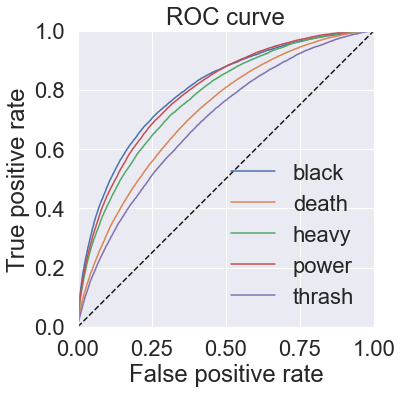

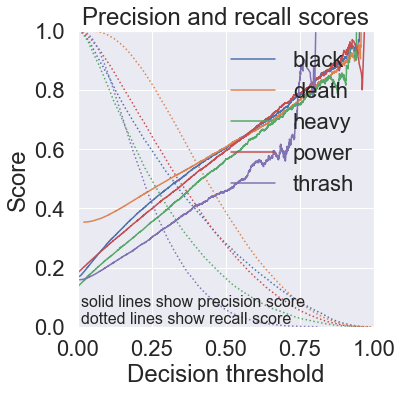

In [22]:
lr_params = dict(
    solver='liblinear',
    C=5.0,
    max_iter=1000,
    random_state=0
)
lr_pipeline = NLPipeline(
    vectorizer=vectorizer,
    resampler=MLSOL(perc_gen_instances=0.3, k=5, random_state=0),
    classifier=BinaryRelevance(
        LogisticRegression(**lr_params),
        require_dense=[False, True]
    )
)

lr_mlc = multilabel_pipeline_cross_val(lr_pipeline, X, y, labels=genres, verbose=2)
lr_mlc.plot_roc_curve()
plt.show()
lr_mlc.plot_precision_recall_curve()
plt.show()

In [23]:
print("Thresholds:", lr_mlc.threshold)
lr_pipeline.fit(X, y, labels=genres)

lr_pipeline.set_threshold(lr_mlc.threshold)

for text in test_corpus:
    print(text)
    lr_pipeline.classify_text(text)
    print()

Thresholds: [0.16887991 0.33686272 0.14670864 0.19904234 0.16859971]


100%|████████████████████████████████████████████████████████████████████████████| 32889/32889 [10:03<00:00, 54.52it/s]



Classification:
NONE

Individual label probabilities:
death      29%
thrash     23%
heavy      19%
black      15%
power       9%

satan
Classification:
BLACK, THRASH

Individual label probabilities:
black      81%
thrash     38%
death      23%
heavy      10%
power       1%

flesh
Classification:
DEATH, BLACK

Individual label probabilities:
death      72%
black      29%
thrash      8%
heavy       1%
power       0%

fight
Classification:
POWER, HEAVY, THRASH

Individual label probabilities:
power      38%
heavy      35%
thrash     32%
death      10%
black       6%

attack
Classification:
THRASH, HEAVY

Individual label probabilities:
thrash     64%
death      21%
heavy      20%
power      16%
black      16%



#### Feature importances

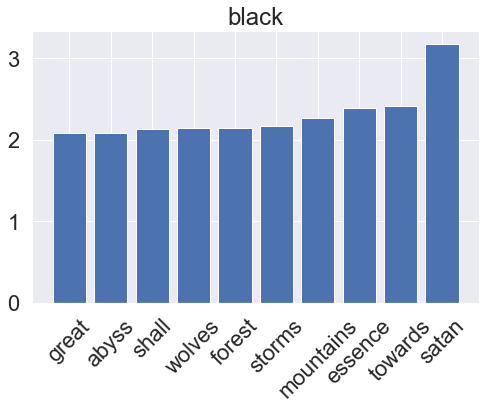

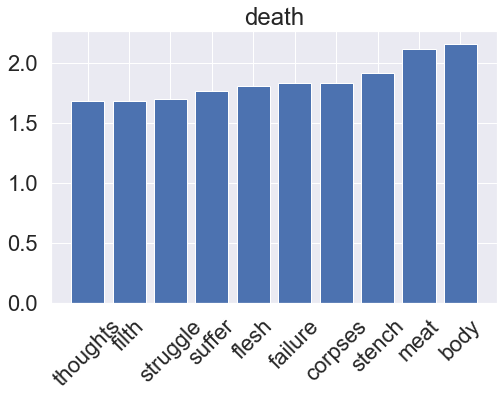

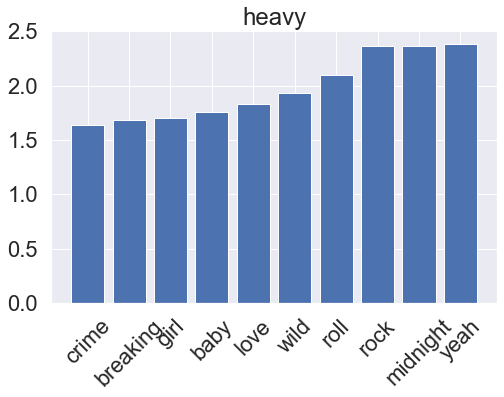

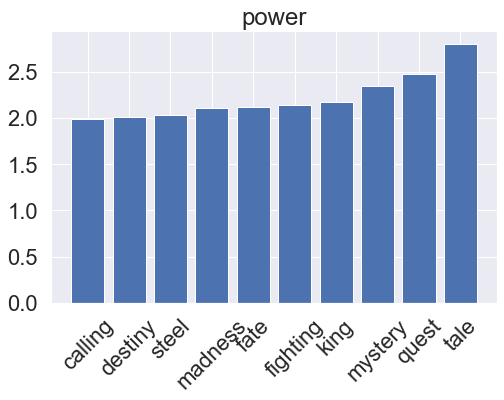

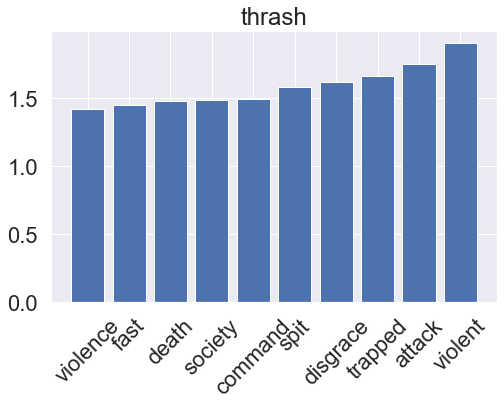

In [28]:
for i, clf in enumerate(lr_pipeline.classifier.classifiers_):
    fi = clf.coef_[0]
    fi_top = fi.argsort()[-10:]
    x_vals = range(len(fi_top))
    fig = plt.figure(figsize=(8, 5))
    plt.bar(x_vals, fi[fi_top])
    plt.title(genres[i])
    plt.xticks(x_vals, np.array(vectorizer.get_feature_names_out())[fi_top], rotation=45)
    plt.show()

<a id='naivebayes'></a>
## Naive Bayes

[Naive Bayes classifiers](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) have long been popular in text classification. The method is rooted in Bayes' Theorem, which states the probability of a particular class $y$ given input $\mathbf{x}=(x_1, \dots, x_n)$ can be written as

$$ P(y|\mathbf{x}) = \frac{P(y)P(\mathbf{x}|y)}{P(\mathbf{x})} $$

where $P(y)$, $P(\mathbf{x}|y)$, and $P(\mathbf{x})$ are known as the prior, likelihood and evidence. The evidence is class-independent and can be ignored when comparing the probabilities of different classes, while the likelihood can be expanded using the chain rule for probabilities as

\begin{align}
P(\mathbf{x}|y) &= P(x_1, \dots, x_n|y)\\
                &= P(x_1|x_2, \dots, x_n, y) P(x_2, \dots, x_n|y)\\
                &= \dots\\
                &= P(x_1|x_2, \dots, x_n, y) P(x_2| x_3 \dots, x_n, y) \dots P(x_{n-1}|x_n, y) P(x_n|y) P(y)
\end{align}

The "naive" assumption is that the input variables $x_i$ are assumed to be mutually independent, so $P(x_i|x_{i+1}, \dots, x_n, y) = P(x_i|y)$. Thus the likelihood becomes a product sum of single-feature probabilities $P(x_i|y)$:

$$ P(\mathbf{x}|y) = P(y) \prod_{i=1}^{n} P(x_i|y) $$

Thus the Naive Bayes classification problem can be expressed as a maximum a posteriori estimation (like maximum-likelihood but with a prior term included that behaves like a regularization parameter (see [this blog post](https://wiseodd.github.io/techblog/2017/01/01/mle-vs-map/) for a quick discussion of MAP and MLE)) with the following classification rule:

$$ \hat{y} = \mathrm{argmax}_k P(y_k) \prod_{i=1}^{n} P(x_i|y_k) $$

The scikit-learn implementation [`NaiveBayes`](https://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes) provides different options for the likelihood distribution $P(x_i|y)$. The Multinomial and Bernoulli algorithms are the most popular for document classification tasks.

<a id='multinomialnb'></a>
#### Multinomial Naive Bayes


--------
Fold 1/3


100%|████████████████████████████████████████████████████████████████████████████| 21927/21927 [04:28<00:00, 81.63it/s]



Binary classification metrics:

label: black
  balanced_accuracy   0.561
  precision           0.665
  recall              0.137
  f1                  0.227
  confusion matrix:
  [[ 29944    425]
   [  5329    845]]

label: death
  balanced_accuracy   0.581
  precision           0.664
  recall              0.223
  f1                  0.334
  confusion matrix:
  [[ 22183   1458]
   [ 10026   2876]]

label: heavy
  balanced_accuracy   0.516
  precision           0.704
  recall              0.035
  f1                  0.067
  confusion matrix:
  [[ 31445     74]
   [  4848    176]]

label: power
  balanced_accuracy   0.502
  precision           0.960
  recall              0.004
  f1                  0.007
  confusion matrix:
  [[ 29845      1]
   [  6673     24]]

label: thrash
  balanced_accuracy   0.500
  precision           0.333
  recall              0.000
  f1                  0.000
  confusion matrix:
  [[ 30736      2]
   [  5804      1]]

Average binary classification scores:
  b

100%|████████████████████████████████████████████████████████████████████████████| 21926/21926 [04:19<00:00, 84.38it/s]



Binary classification metrics:

label: black
  balanced_accuracy   0.564
  precision           0.659
  recall              0.142
  f1                  0.234
  confusion matrix:
  [[ 29918    453]
   [  5297    877]]

label: death
  balanced_accuracy   0.579
  precision           0.659
  recall              0.220
  f1                  0.330
  confusion matrix:
  [[ 22176   1467]
   [ 10061   2841]]

label: heavy
  balanced_accuracy   0.515
  precision           0.735
  recall              0.031
  f1                  0.060
  confusion matrix:
  [[ 31465     57]
   [  4865    158]]

label: power
  balanced_accuracy   0.502
  precision           0.825
  recall              0.005
  f1                  0.010
  confusion matrix:
  [[ 29841      7]
   [  6664     33]]

label: thrash
  balanced_accuracy   0.500
  precision           0.667
  recall              0.000
  f1                  0.001
  confusion matrix:
  [[ 30740      1]
   [  5802      2]]

Average binary classification scores:
  b

100%|████████████████████████████████████████████████████████████████████████████| 21926/21926 [04:22<00:00, 83.39it/s]



Binary classification metrics:

label: black
  balanced_accuracy   0.563
  precision           0.644
  recall              0.141
  f1                  0.232
  confusion matrix:
  [[ 29890    482]
   [  5301    872]]

label: death
  balanced_accuracy   0.581
  precision           0.667
  recall              0.222
  f1                  0.333
  confusion matrix:
  [[ 22211   1432]
   [ 10038   2864]]

label: heavy
  balanced_accuracy   0.518
  precision           0.716
  recall              0.038
  f1                  0.071
  confusion matrix:
  [[ 31446     75]
   [  4835    189]]

label: power
  balanced_accuracy   0.502
  precision           0.800
  recall              0.004
  f1                  0.007
  confusion matrix:
  [[ 29841      6]
   [  6674     24]]

label: thrash
  balanced_accuracy   0.500
  precision           0.667
  recall              0.000
  f1                  0.001
  confusion matrix:
  [[ 30739      1]
   [  5803      2]]

Average binary classification scores:
  b

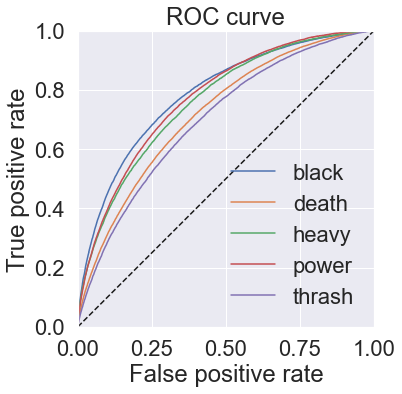

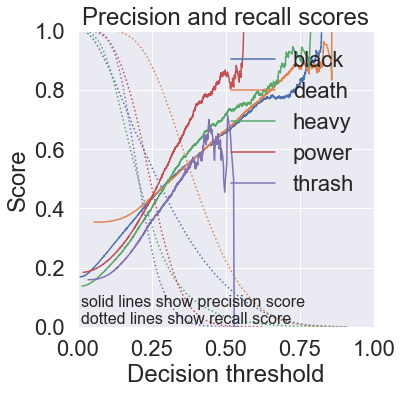

In [29]:
multinomial_pipeline = NLPipeline(
    vectorizer=vectorizer,
    resampler=MLSOL(perc_gen_instances=0.3, k=5, random_state=0),
    classifier=BinaryRelevance(
        MultinomialNB(alpha=1.0),
        require_dense=[False, True]
    )
)
multinomial_mlc = multilabel_pipeline_cross_val(multinomial_pipeline, X, y, labels=genres, verbose=2)
multinomial_mlc.plot_roc_curve()
plt.show()
multinomial_mlc.plot_precision_recall_curve()
plt.show()

In [30]:
print(multinomial_mlc.threshold)
multinomial_pipeline.fit(X, y, labels=genres)
multinomial_pipeline.set_threshold(multinomial_mlc.threshold)

for text in test_corpus:
    print(text)
    multinomial_pipeline.classify_text(text)
    print()

[0.17336195 0.33192809 0.15649294 0.19828029 0.18175247]


100%|████████████████████████████████████████████████████████████████████████████| 32889/32889 [09:41<00:00, 56.52it/s]



Classification:
DEATH

Individual label probabilities:
death      34%
power      19%
thrash     18%
black      17%
heavy      16%

satan
Classification:
BLACK, THRASH

Individual label probabilities:
black      52%
death      33%
thrash     26%
heavy      12%
power       9%

flesh
Classification:
DEATH, BLACK

Individual label probabilities:
death      56%
black      27%
thrash     17%
power       6%
heavy       6%

fight
Classification:
POWER, HEAVY, THRASH

Individual label probabilities:
power      33%
heavy      24%
death      22%
thrash     22%
black      11%

attack
Classification:
THRASH, POWER, HEAVY

Individual label probabilities:
thrash     35%
death      29%
power      20%
heavy      20%
black      17%



#### Feature importances

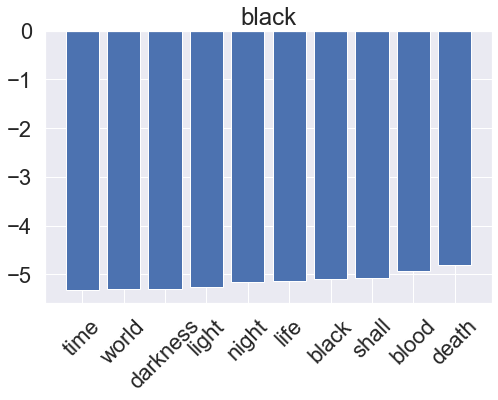

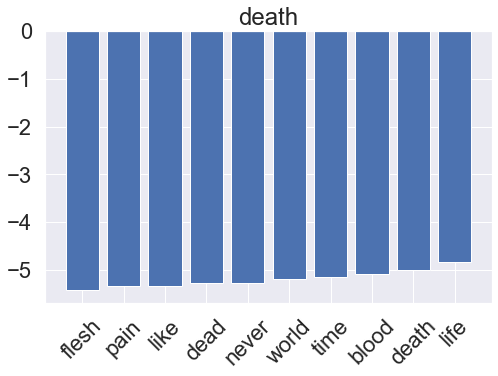

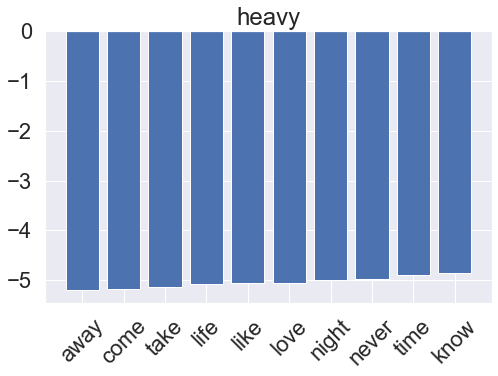

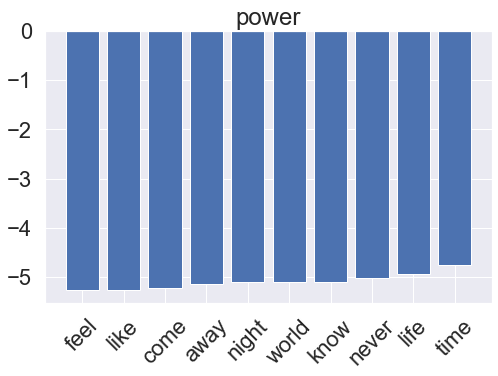

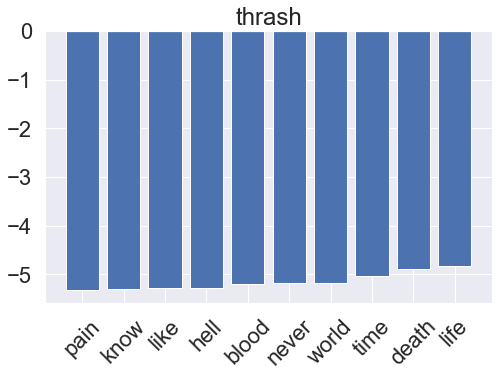

In [33]:
for i, clf in enumerate(multinomial_pipeline.classifier.classifiers_):
    fi = clf.coef_[0]
    fi_top = fi.argsort()[-10:]
    x_vals = range(len(fi_top))
    fig = plt.figure(figsize=(8, 5))
    plt.bar(x_vals, fi[fi_top])
    plt.title(genres[i])
    plt.xticks(x_vals, np.array(vectorizer.get_feature_names_out())[fi_top], rotation=45)
    plt.show()

<a id='complementnb'></a>
#### Complement multinomial Naive Bayes

fold 1/3


C:\Users\philippe\Anaconda3\envs\metallyrics\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['insermi'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


fold 2/3
fold 3/3

Binary classification metrics:

label: black
  balanced_accuracy   0.717
  precision           0.451
  recall              0.575
  f1                  0.506
  confusion matrix:
  [[ 41641   6805]
   [  4133   5595]]

label: death
  balanced_accuracy   0.686
  precision           0.511
  recall              0.740
  f1                  0.605
  confusion matrix:
  [[ 24177  14086]
   [  5171  14740]]

label: heavy
  balanced_accuracy   0.500
  precision           0.667
  recall              0.000
  f1                  0.000
  confusion matrix:
  [[ 48574      1]
   [  9597      2]]

label: power
  balanced_accuracy   0.719
  precision           0.444
  recall              0.638
  f1                  0.524
  confusion matrix:
  [[ 37119   9344]
   [  4236   7475]]

label: thrash
  balanced_accuracy   0.651
  precision           0.326
  recall              0.544
  f1                  0.408
  confusion matrix:
  [[ 36304  11565]
   [  4701   5604]]

Average binary classifi

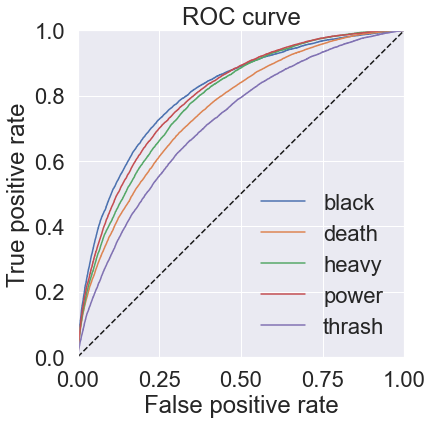

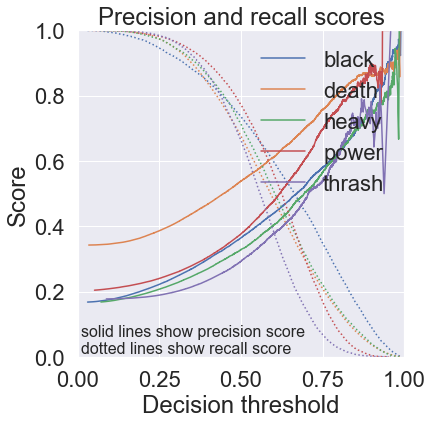

In [6]:
pipeline = Pipeline(
    vectorizer=TfidfVectorizer(stop_words=stopwords, max_features=3000),
    resampler=MLSOL(perc_gen_instances=0.3, k=5),
    classifier=BinaryRelevance(
        ComplementNB(),
        require_dense=[False, True]
    )
)
mlc, _ = multilabel_pipeline_cross_val(pipeline, X, y, labels=genres)
mlc.print_report()
best_thresh = mlc.thresh
if isinstance(best_thresh, float):
    best_thresh = np.ones(mlc.n_labels) * best_thresh
if len(best_thresh.shape) == 2:
    best_thresh = best_thresh.mean(0)
print("\nDecision thresholds:")
for i, label in enumerate(mlc.labels):
    print(f"  {label:<10s}: {best_thresh[i]:.2f}")
mlc.plot_roc_curve()
plt.show()
mlc.plot_precision_recall_curve()
plt.show()

<a id='bernoullinb'></a>
#### Bernoulli Naive Bayes


--------
Fold 1/3


100%|███████████████████████████████████████████████████████████████████████████████| 270/270 [00:00<00:00, 909.09it/s]



Binary classification metrics:

label: black
  balanced_accuracy   0.681
  precision           0.357
  recall              0.833
  f1                  0.500
  confusion matrix:
  [[   182    162]
   [    18     90]]

label: death
  balanced_accuracy   0.636
  precision           0.540
  recall              0.484
  f1                  0.510
  confusion matrix:
  [[   236     63]
   [    79     74]]

label: power
  balanced_accuracy   0.659
  precision           0.306
  recall              0.543
  f1                  0.392
  confusion matrix:
  [[   296     86]
   [    32     38]]

label: thrash
  balanced_accuracy   0.538
  precision           0.203
  recall              0.368
  f1                  0.262
  confusion matrix:
  [[   266    110]
   [    48     28]]

Average binary classification scores:
  balanced_accuracy   0.63 +/- 0.11
  precision           0.35 +/- 0.24
  recall              0.56 +/- 0.34
  f1                  0.42 +/- 0.20

Multi-label classification metrics:
  accur

100%|███████████████████████████████████████████████████████████████████████████████| 271/271 [00:00<00:00, 912.37it/s]



Binary classification metrics:

label: black
  balanced_accuracy   0.717
  precision           0.399
  recall              0.824
  f1                  0.538
  confusion matrix:
  [[   209    134]
   [    19     89]]

label: death
  balanced_accuracy   0.654
  precision           0.556
  recall              0.523
  f1                  0.539
  confusion matrix:
  [[   234     64]
   [    73     80]]

label: power
  balanced_accuracy   0.662
  precision           0.305
  recall              0.557
  f1                  0.394
  confusion matrix:
  [[   292     89]
   [    31     39]]

label: thrash
  balanced_accuracy   0.561
  precision           0.227
  recall              0.395
  f1                  0.288
  confusion matrix:
  [[   273    102]
   [    46     30]]

Average binary classification scores:
  balanced_accuracy   0.65 +/- 0.11
  precision           0.37 +/- 0.24
  recall              0.57 +/- 0.31
  f1                  0.44 +/- 0.21

Multi-label classification metrics:
  accur

100%|███████████████████████████████████████████████████████████████████████████████| 270/270 [00:00<00:00, 902.92it/s]



Binary classification metrics:

label: black
  balanced_accuracy   0.674
  precision           0.371
  recall              0.752
  f1                  0.497
  confusion matrix:
  [[   204    139]
   [    27     82]]

label: death
  balanced_accuracy   0.721
  precision           0.611
  recall              0.651
  f1                  0.631
  confusion matrix:
  [[   237     63]
   [    53     99]]

label: power
  balanced_accuracy   0.702
  precision           0.350
  recall              0.614
  f1                  0.446
  confusion matrix:
  [[   302     80]
   [    27     43]]

label: thrash
  balanced_accuracy   0.572
  precision           0.230
  recall              0.447
  f1                  0.304
  confusion matrix:
  [[   262    114]
   [    42     34]]

Average binary classification scores:
  balanced_accuracy   0.67 +/- 0.11
  precision           0.39 +/- 0.28
  recall              0.62 +/- 0.22
  f1                  0.47 +/- 0.23

Multi-label classification metrics:
  accur

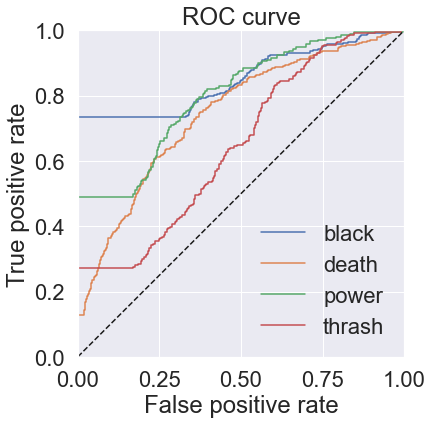

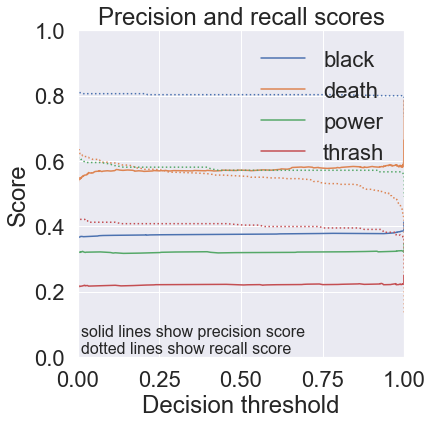

In [30]:
bernoulli_pipeline = NLPipeline(
    vectorizer=vectorizer,
    resampler=MLSOL(perc_gen_instances=0.3, k=5, random_state=0),
    classifier=BinaryRelevance(
        BernoulliNB(alpha=1.0),
        require_dense=[False, True]
    )
)
bernoulli_mlc = multilabel_pipeline_cross_val(bernoulli_pipeline, X, y, labels=genres, verbose=2)
bernoulli_mlc.plot_roc_curve()
plt.show()
bernoulli_mlc.plot_precision_recall_curve()
plt.show()

In [31]:
print(bernoulli_mlc.threshold)
bernoulli_pipeline.fit(X, y, labels=genres)
bernoulli_pipeline.set_threshold(bernoulli_mlc.threshold)

for text in test_corpus:
    print(text)
    bernoulli_pipeline.classify_text(text)
    print()

[9.99999509e-01 1.09354249e-02 6.28158439e-17 6.47363821e-19]


100%|███████████████████████████████████████████████████████████████████████████████| 406/406 [00:00<00:00, 828.57it/s]


AttributeError: 'NLPipeline' object has no attribute 'set_thresholds'

#### Feature importances

In [ ]:
for genre, clf in zip(genres, bernoulli_pipeline.classifier.classifiers_):
    print(genre)
    fi = clf.coef_[0]
    fi_top = fi.argsort()[-10:]
    x_vals = range(len(fi_top))
    plt.bar(x_vals, fi[fi_top])
    plt.xticks(x_vals, np.array(bernoulli_pipeline.vocabulary)[fi_top], rotation=45)
    plt.show()

<a id='rf'></a>
## Random forest classifier

The random forest classifier is a popular choice in classification problems, especially when overfitting is a concern. As an ensemble model, the random forest does a good job of minimizing bias by averaging out the contributions of many hundreds or thousands of predictors.


--------
Fold 1/3


100%|█████████████████████████████████████████████████████████████████████████████| 7309/7309 [00:31<00:00, 230.13it/s]



Binary classification metrics:

label: black
  balanced_accuracy   0.522
  precision           0.756
  recall              0.048
  f1                  0.090
  confusion matrix:
  [[ 10090     32]
   [  1960     99]]

label: death
  balanced_accuracy   0.600
  precision           0.622
  recall              0.298
  f1                  0.403
  confusion matrix:
  [[  7101    778]
   [  3020   1282]]

label: heavy
  balanced_accuracy   0.507
  precision           0.885
  recall              0.014
  f1                  0.027
  confusion matrix:
  [[ 10508      3]
   [  1647     23]]

label: power
  balanced_accuracy   0.504
  precision           0.850
  recall              0.008
  f1                  0.015
  confusion matrix:
  [[  9948      3]
   [  2213     17]]

label: thrash
  balanced_accuracy   0.501
  precision           1.000
  recall              0.002
  f1                  0.004
  confusion matrix:
  [[ 10243      0]
   [  1934      4]]

Average binary classification scores:
  b

100%|█████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.20it/s]



Binary classification metrics:

label: black
  balanced_accuracy   0.521
  precision           0.843
  recall              0.044
  f1                  0.084
  confusion matrix:
  [[ 10106     17]
   [  1968     91]]

label: death
  balanced_accuracy   0.603
  precision           0.612
  recall              0.316
  f1                  0.416
  confusion matrix:
  [[  7020    861]
   [  2944   1357]]

label: heavy
  balanced_accuracy   0.507
  precision           0.828
  recall              0.014
  f1                  0.028
  confusion matrix:
  [[ 10507      5]
   [  1646     24]]

label: power
  balanced_accuracy   0.503
  precision           0.765
  recall              0.006
  f1                  0.012
  confusion matrix:
  [[  9947      4]
   [  2218     13]]

label: thrash
  balanced_accuracy   0.501
  precision           0.750
  recall              0.003
  f1                  0.006
  confusion matrix:
  [[ 10242      2]
   [  1932      6]]

Average binary classification scores:
  b

100%|█████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.88it/s]



Binary classification metrics:

label: black
  balanced_accuracy   0.518
  precision           0.814
  recall              0.038
  f1                  0.073
  confusion matrix:
  [[ 10104     18]
   [  1981     79]]

label: death
  balanced_accuracy   0.602
  precision           0.620
  recall              0.306
  f1                  0.410
  confusion matrix:
  [[  7072    808]
   [  2986   1316]]

label: heavy
  balanced_accuracy   0.506
  precision           0.880
  recall              0.013
  f1                  0.026
  confusion matrix:
  [[ 10509      3]
   [  1648     22]]

label: power
  balanced_accuracy   0.503
  precision           0.889
  recall              0.007
  f1                  0.014
  confusion matrix:
  [[  9949      2]
   [  2215     16]]

label: thrash
  balanced_accuracy   0.502
  precision           0.833
  recall              0.005
  f1                  0.010
  confusion matrix:
  [[ 10243      2]
   [  1927     10]]

Average binary classification scores:
  b

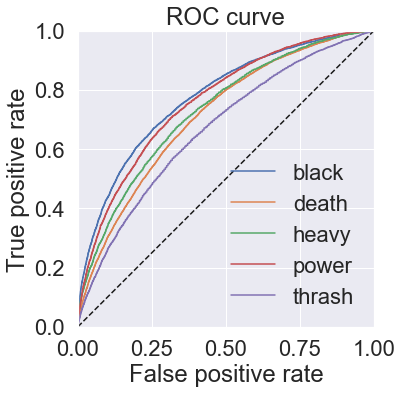

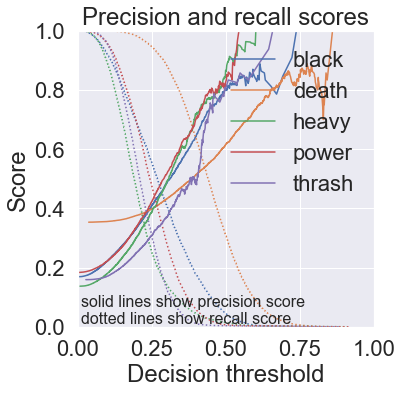

In [11]:
rf_params = dict(
    n_estimators=1000,
    max_features='auto',
    bootstrap=True,
    n_jobs=-1,
    random_state=0
)
rf_pipeline = NLPipeline(
    vectorizer=vectorizer,
    resampler=MLSOL(perc_gen_instances=0.3, k=5, random_state=0),
    classifier=BinaryRelevance(
        RandomForestClassifier(**rf_params),
        require_dense=[False, True]
    )
)
rf_mlc = multilabel_pipeline_cross_val(rf_pipeline, X[::3], y[::3], labels=genres, verbose=2)
rf_mlc.plot_roc_curve()
plt.show()
rf_mlc.plot_precision_recall_curve()
plt.show()

In [12]:
print(rf_mlc.threshold)
rf_pipeline.fit(X, y, labels=genres)
rf_pipeline.set_threshold(rf_mlc.threshold)

for text in test_corpus:
    print(text)
    rf_pipeline.classify_text(text)
    print()

[0.20501235 0.38917857 0.15568    0.19583333 0.19222251]


100%|████████████████████████████████████████████████████████████████████████████| 32889/32889 [10:16<00:00, 53.37it/s]



Classification:
NONE

Individual label probabilities:
death      22%
thrash     19%
heavy       7%
black       5%
power       4%

satan
Classification:
BLACK, DEATH

Individual label probabilities:
black      84%
death      40%
thrash      9%
heavy       5%
power       1%

flesh
Classification:
BLACK

Individual label probabilities:
black      49%
death       6%
thrash      0%
heavy       0%
power       0%

fight
Classification:
NONE

Individual label probabilities:
thrash      6%
death       6%
black       6%
power       3%
heavy       1%

attack
Classification:
NONE

Individual label probabilities:
death      15%
power       6%
thrash      5%
heavy       4%
black       3%



#### Feature importances

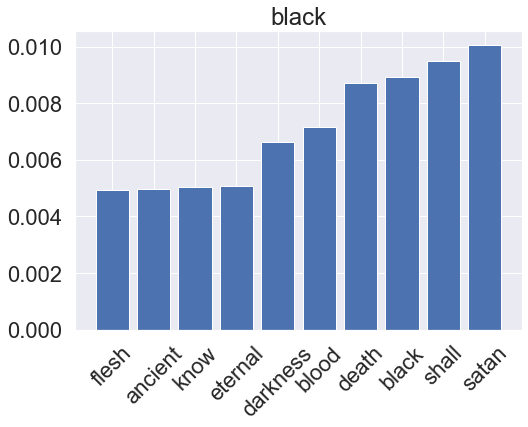

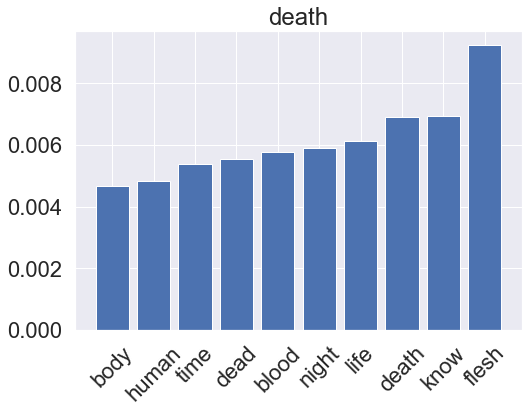

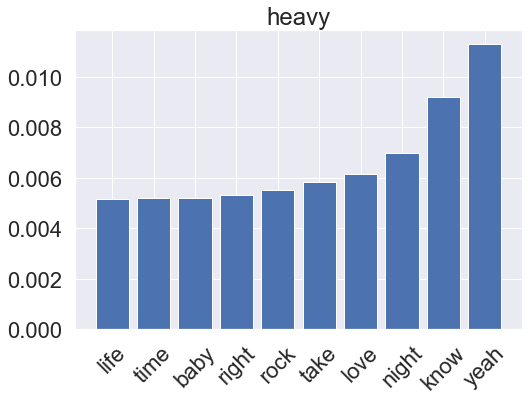

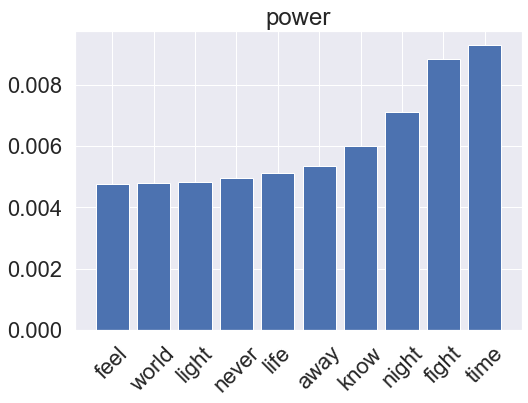

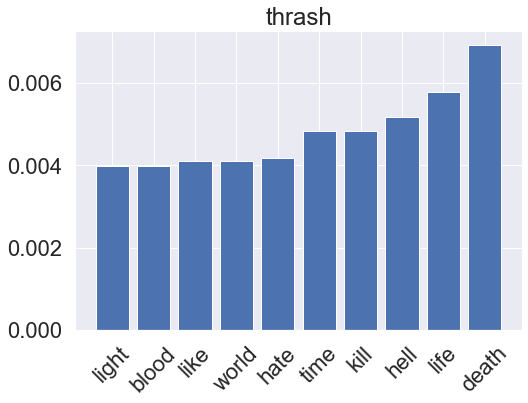

In [21]:
for genre, clf in zip(genres, rf_pipeline.classifier.classifiers_):
    fi = clf.feature_importances_
    fi_top = fi.argsort()[-10:]
    x_vals = range(len(fi_top))
    plt.bar(x_vals, fi[fi_top])
    plt.title(genre)
    plt.xticks(x_vals, np.array(vectorizer.get_feature_names_out())[fi_top], rotation=45)
    plt.show()

<a id='gbm'></a>
## Gradient boosting model

Going beyond random forests, gradient boosting models (GBMs) expand on the idea of ensembling in a way that typically outperforms random forests.
The idea is to ensemble many weak estimators, in this case decision trees, sequentially by fitting each one to the residual of the previous.
There are a few good GBM libraries out there: I'm using LightGBM here, but other popular choices include XGBoost, CatBoost, and sci-kit learn's implementation.


--------
Fold 1/3


100%|█████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.44it/s]



Binary classification metrics:

label: black
  balanced_accuracy   0.590
  precision           0.626
  recall              0.204
  f1                  0.308
  confusion matrix:
  [[  9871    252]
   [  1638    421]]

label: death
  balanced_accuracy   0.610
  precision           0.580
  recall              0.364
  f1                  0.447
  confusion matrix:
  [[  6747   1134]
   [  2737   1564]]

label: heavy
  balanced_accuracy   0.548
  precision           0.607
  recall              0.107
  f1                  0.182
  confusion matrix:
  [[ 10396    116]
   [  1491    179]]

label: power
  balanced_accuracy   0.583
  precision           0.619
  recall              0.193
  f1                  0.295
  confusion matrix:
  [[  9687    265]
   [  1799    431]]

label: thrash
  balanced_accuracy   0.514
  precision           0.520
  recall              0.034
  f1                  0.063
  confusion matrix:
  [[ 10184     60]
   [  1873     65]]

Average binary classification scores:
  b

100%|█████████████████████████████████████████████████████████████████████████████| 7309/7309 [00:32<00:00, 225.27it/s]



Binary classification metrics:

label: black
  balanced_accuracy   0.586
  precision           0.574
  recall              0.203
  f1                  0.299
  confusion matrix:
  [[  9813    309]
   [  1642    417]]

label: death
  balanced_accuracy   0.613
  precision           0.584
  recall              0.370
  f1                  0.453
  confusion matrix:
  [[  6748   1131]
   [  2712   1590]]

label: heavy
  balanced_accuracy   0.548
  precision           0.630
  recall              0.106
  f1                  0.181
  confusion matrix:
  [[ 10407    104]
   [  1493    177]]

label: power
  balanced_accuracy   0.580
  precision           0.601
  recall              0.188
  f1                  0.287
  confusion matrix:
  [[  9671    279]
   [  1811    420]]

label: thrash
  balanced_accuracy   0.510
  precision           0.420
  recall              0.028
  f1                  0.053
  confusion matrix:
  [[ 10168     76]
   [  1882     55]]

Average binary classification scores:
  b

100%|█████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.01it/s]



Binary classification metrics:

label: black
  balanced_accuracy   0.592
  precision           0.604
  recall              0.213
  f1                  0.315
  confusion matrix:
  [[  9835    287]
   [  1622    438]]

label: death
  balanced_accuracy   0.619
  precision           0.588
  recall              0.386
  f1                  0.466
  confusion matrix:
  [[  6717   1163]
   [  2643   1659]]

label: heavy
  balanced_accuracy   0.549
  precision           0.610
  recall              0.110
  f1                  0.186
  confusion matrix:
  [[ 10395    117]
   [  1487    183]]

label: power
  balanced_accuracy   0.585
  precision           0.603
  recall              0.200
  f1                  0.300
  confusion matrix:
  [[  9657    294]
   [  1785    446]]

label: thrash
  balanced_accuracy   0.516
  precision           0.446
  recall              0.042
  f1                  0.077
  confusion matrix:
  [[ 10142    102]
   [  1856     82]]

Average binary classification scores:
  b

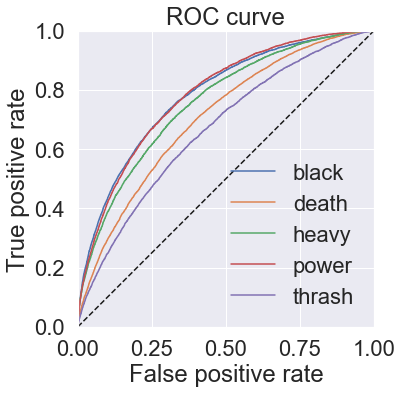

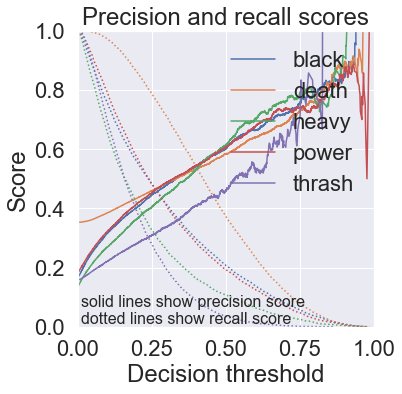

In [24]:
gbm_params = dict(
    boosting_type='dart',
    n_estimators=1000,
#     num_leaves=15,
    num_leaves=63,
#     max_bin=511,
#     learning_rate=(1/10.) * 0.1,
#     num_iterations=10 * 100,
    n_jobs=-1,
    random_state=0
)
gbm_pipeline = NLPipeline(
    vectorizer=vectorizer,
    resampler=MLSOL(perc_gen_instances=0.3, k=5, random_state=0),
    classifier=BinaryRelevance(
        lgb.LGBMClassifier(**gbm_params),
        require_dense=[False, True]
    )
)
gbm_mlc = multilabel_pipeline_cross_val(gbm_pipeline, X[::3], y[::3], labels=genres, verbose=2)
gbm_mlc.plot_roc_curve()
plt.show()
gbm_mlc.plot_precision_recall_curve()
plt.show()

In [25]:
print(gbm_mlc.threshold)
gbm_pipeline.fit(X, y, labels=genres)

gbm_pipeline.set_threshold(gbm_mlc.threshold)

for text in test_corpus:
    print(text)
    gbm_pipeline.classify_text(text)
    print()

[0.11440158 0.33268319 0.08962132 0.12956028 0.12367164]


100%|████████████████████████████████████████████████████████████████████████████| 32889/32889 [09:55<00:00, 55.24it/s]



Classification:
DEATH, THRASH, BLACK, HEAVY

Individual label probabilities:
death      35%
thrash     22%
black      19%
heavy      11%
power       4%

satan
Classification:
BLACK, THRASH, HEAVY

Individual label probabilities:
black      65%
death      33%
thrash     20%
heavy      10%
power       2%

flesh
Classification:
DEATH, BLACK

Individual label probabilities:
death      53%
black      23%
thrash     12%
heavy       6%
power       2%

fight
Classification:
NONE

Individual label probabilities:
death      27%
thrash     23%
heavy      15%
black      15%
power       9%

attack
Classification:
THRASH, BLACK, HEAVY

Individual label probabilities:
thrash     29%
death      27%
black      19%
heavy      11%
power       5%



### Feature importances

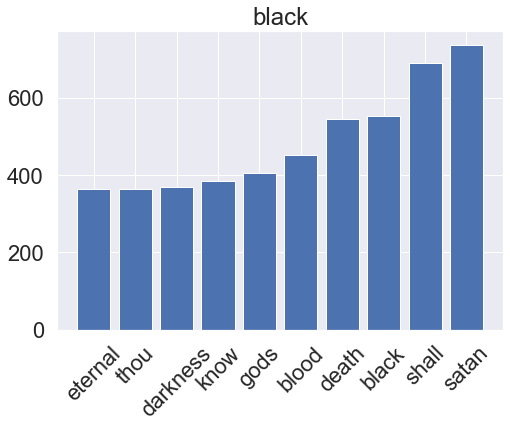

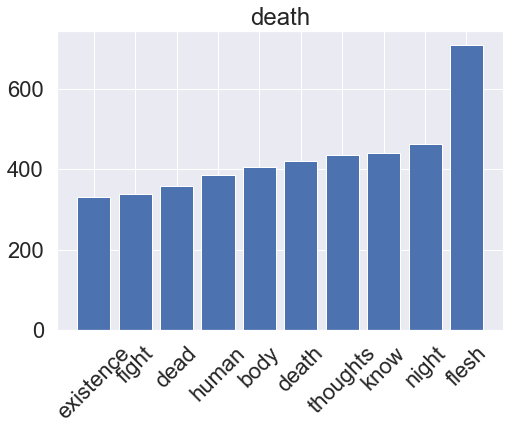

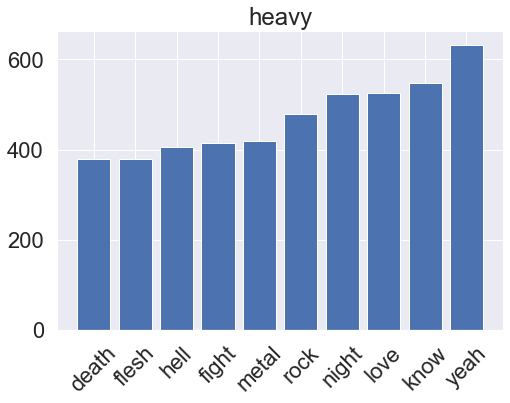

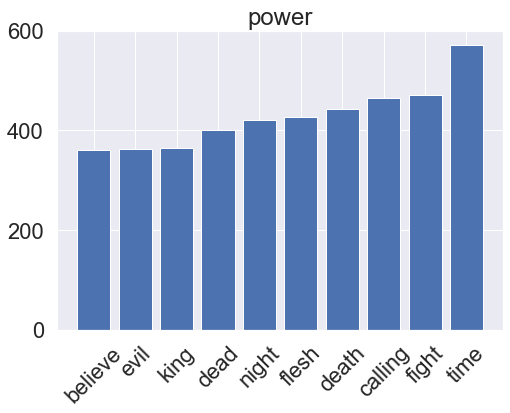

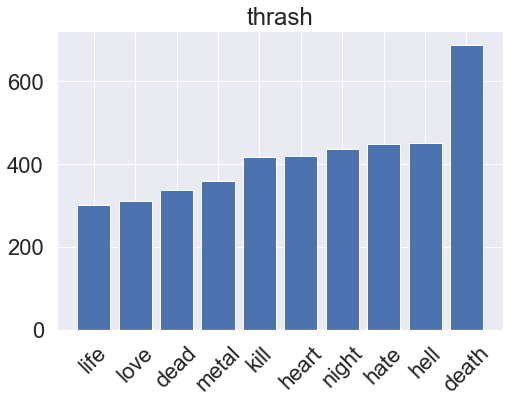

In [26]:
for genre, clf in zip(genres, gbm_pipeline.classifier.classifiers_):
    fi = clf.feature_importances_
    fi_top = fi.argsort()[-10:]
    x_vals = range(len(fi_top))
    plt.bar(x_vals, fi[fi_top])
    plt.title(genre)
    plt.xticks(x_vals, np.array(vectorizer.get_feature_names_out())[fi_top], rotation=45)
    plt.show()

<a id='nn'></a>
## Neural network

In [11]:
def create_keras_model(input_dim, output_dim):
    model = Sequential()
    model.add(layers.Dense(1024, input_dim=input_dim, activation='relu'))
    # model.add(layers.Dropout(rate=0.2))
    # model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(output_dim, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
    return model

Best so far: 64 epochs, 128 batches, hidden layer of 256 nodes.

Low epochs underfits. 128 epochs works too, but not really worth.

Low batch size kind of underfits?

More hidden layer nodes overfits. Fewer kind of underfits.

C:\Users\philn\AppData\Local\Temp\ipykernel_1392\2768025053.py:23: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  classifier=KerasClassifier(create_keras_model, **keras_params),



--------
Fold 1/3


  1%|▋                                                                              | 69/7308 [00:00<00:33, 215.35it/s]E:\Projects\metallyrics\analyses\lyrics\notebooks\../scripts\mlsol.py:115: RuntimeWarning: invalid value encountered in double_scalars
  cd = dist_seed / (dist_seed - dist_reference)
100%|█████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.24it/s]


Epoch 1/64
99/99 [==============================] - 1s 9ms/step - loss: 0.4795 - binary_accuracy: 0.7983 - val_loss: 0.5016 - val_binary_accuracy: 0.7657
Epoch 2/64
99/99 [==============================] - 1s 8ms/step - loss: 0.4123 - binary_accuracy: 0.8160 - val_loss: 0.4840 - val_binary_accuracy: 0.7720
Epoch 3/64
99/99 [==============================] - 1s 8ms/step - loss: 0.3983 - binary_accuracy: 0.8226 - val_loss: 0.4772 - val_binary_accuracy: 0.7731
Epoch 4/64
99/99 [==============================] - 1s 8ms/step - loss: 0.3894 - binary_accuracy: 0.8265 - val_loss: 0.4772 - val_binary_accuracy: 0.7733
Epoch 5/64
99/99 [==============================] - 1s 7ms/step - loss: 0.3803 - binary_accuracy: 0.8314 - val_loss: 0.4731 - val_binary_accuracy: 0.7752
Epoch 6/64
99/99 [==============================] - 1s 8ms/step - loss: 0.3689 - binary_accuracy: 0.8380 - val_loss: 0.4655 - val_binary_accuracy: 0.7778
Epoch 7/64
99/99 [==============================] - 1s 10ms/step - loss: 0.3

C:\Users\philn\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
100%|█████████████████████████████████████████████████████████████████████████████| 7309/7309 [00:33<00:00, 216.46it/s]


Epoch 1/64
99/99 [==============================] - 1s 8ms/step - loss: 0.4786 - binary_accuracy: 0.8002 - val_loss: 0.4989 - val_binary_accuracy: 0.7708
Epoch 2/64
99/99 [==============================] - 1s 7ms/step - loss: 0.4127 - binary_accuracy: 0.8173 - val_loss: 0.4822 - val_binary_accuracy: 0.7737
Epoch 3/64
99/99 [==============================] - 1s 7ms/step - loss: 0.3983 - binary_accuracy: 0.8229 - val_loss: 0.4752 - val_binary_accuracy: 0.7775
Epoch 4/64
99/99 [==============================] - 1s 7ms/step - loss: 0.3896 - binary_accuracy: 0.8268 - val_loss: 0.4706 - val_binary_accuracy: 0.7783
Epoch 5/64
99/99 [==============================] - 1s 7ms/step - loss: 0.3801 - binary_accuracy: 0.8320 - val_loss: 0.4693 - val_binary_accuracy: 0.7780
Epoch 6/64
99/99 [==============================] - 1s 7ms/step - loss: 0.3685 - binary_accuracy: 0.8387 - val_loss: 0.4644 - val_binary_accuracy: 0.7819
Epoch 7/64
99/99 [==============================] - 1s 7ms/step - loss: 0.35

C:\Users\philn\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
100%|█████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 221.10it/s]


Epoch 1/64
99/99 [==============================] - 1s 8ms/step - loss: 0.4760 - binary_accuracy: 0.8021 - val_loss: 0.4779 - val_binary_accuracy: 0.7830
Epoch 2/64
99/99 [==============================] - 1s 7ms/step - loss: 0.4108 - binary_accuracy: 0.8172 - val_loss: 0.4525 - val_binary_accuracy: 0.7914
Epoch 3/64
99/99 [==============================] - 1s 7ms/step - loss: 0.3968 - binary_accuracy: 0.8229 - val_loss: 0.4451 - val_binary_accuracy: 0.7927
Epoch 4/64
99/99 [==============================] - 1s 7ms/step - loss: 0.3881 - binary_accuracy: 0.8269 - val_loss: 0.4422 - val_binary_accuracy: 0.7953
Epoch 5/64
99/99 [==============================] - 1s 7ms/step - loss: 0.3792 - binary_accuracy: 0.8326 - val_loss: 0.4322 - val_binary_accuracy: 0.7980
Epoch 6/64
99/99 [==============================] - 1s 7ms/step - loss: 0.3679 - binary_accuracy: 0.8392 - val_loss: 0.4278 - val_binary_accuracy: 0.8004
Epoch 7/64
99/99 [==============================] - 1s 7ms/step - loss: 0.35

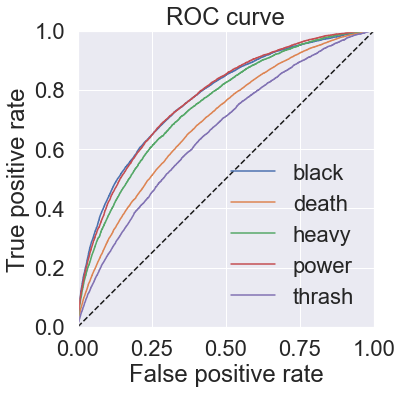

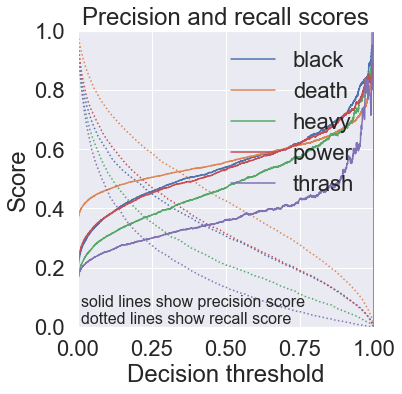

In [52]:
keras_params = dict(
    input_dim=vectorizer.max_features,
    output_dim=y.shape[1],
    epochs=64,
    batch_size=256,
)

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=10,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=True
    )
]

keras_pipeline = NLPipeline(
    vectorizer=vectorizer,
    resampler=MLSOL(perc_gen_instances=0.3, k=5, random_state=0),
    classifier=KerasClassifier(create_keras_model, **keras_params),
    pad_features=True,
)
keras_mlc = multilabel_pipeline_cross_val(keras_pipeline, X[::3], y[::3], labels=genres, verbose=2, keras=True, callbacks=callbacks)
keras_mlc.plot_roc_curve()
plt.show()
keras_mlc.plot_precision_recall_curve()
plt.show()

In [54]:
print("Thresholds:", keras_mlc.threshold)
keras_pipeline.fit(X, y, labels=genres, verbose=0)

keras_pipeline.set_threshold(keras_mlc.threshold)

for text in test_corpus:
    print(text)
    keras_pipeline.classify_text(text)
    print()

Thresholds: [0.04349495 0.17454619 0.03878406 0.06144459 0.04794146]


C:\Users\philn\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
100%|████████████████████████████████████████████████████████████████████████████| 32889/32889 [10:27<00:00, 52.44it/s]



Classification:
THRASH, HEAVY, POWER

Individual label probabilities:
thrash     22%
heavy      18%
death      15%
power      14%
black       1%

satan
Classification:
BLACK

Individual label probabilities:
black     100%
thrash      1%
heavy       0%
death       0%
power       0%

flesh
Classification:
BLACK

Individual label probabilities:
black     100%
death       1%
thrash      0%
power       0%
heavy       0%

fight
Classification:
NONE

Individual label probabilities:
black       0%
death       0%
thrash      0%
heavy       0%
power       0%

attack
Classification:
NONE

Individual label probabilities:
power       1%
black       0%
heavy       0%
thrash      0%
death       0%

